# Decision Trees

Decision trees are one of the oldest ML methods and are well suited for non-linear datasets. However, they tend to overfit and are not very good at additively structured data.

The idea is to perform greedy, top-down, recursive partitioning of a dataset.

This involves recursively splitting the dataset until all the data is exhausted or a convergence criteria is met. 

For a two way split, Rp is the parent node, R1 and R2 are the children:

         |Rp|
       /      \
     |R1|    |R2|
     
One way to define the split is with a Gini loss:

$L(R) = \sum_c p_c(1 - p_c)$

## Dataset

In [188]:
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt
import numpy as np
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

Text(0, 0.5, 'x2')

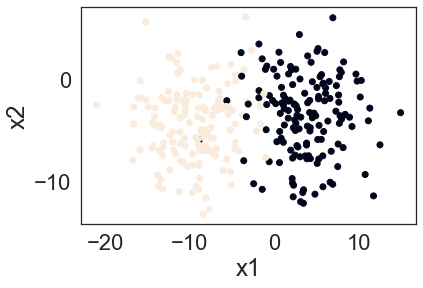

In [189]:
seed = 123
np.random.seed(seed)
X, y = make_circles(n_samples=300, noise=.1)
X, y = make_blobs(n_samples=[150, 150], cluster_std=4.0)
plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel('x1')
plt.ylabel('x2')

## From scratch

In [190]:
def gini_loss(m, y):
    px = np.array([m[y==i].sum()/m.sum() for i in np.unique(y)])
    return 1 - np.sum(px**2)

def sort_data(x_feature, y):
    idx =  np.lexsort([y, x_feature])
    return x_feature[idx], y[idx]

def get_threshold(x, y):
    thresholds = (x[:-1] + x[1:])/2
    h_x = np.zeros(len(thresholds))
    for i,t in enumerate(thresholds):
        m = x < t
        ratio = m.sum()/len(m)
        h_x[i] = ratio * gini_loss(m, y) + (1-ratio) * gini_loss(~m, y)
    
    best_hx = min(h_x)
    
    if np.sum(best_hx==h_x) > 1:
        print('Multiple threshold choices')
        idx = np.random.choice(np.arange(len(h_x))[best_hx==h_x])
    else:
        idx = np.argmin(h_x)
    
    return min(h_x), thresholds[idx]

def split_leaf(X, y):
    R_p = X.copy()
    y_p = y.copy()

    best_score = 100
    for i in range(R_p.shape[1]):
        score, thres = get_threshold(*sort_data(R_p[:,i].copy(), y_p))

        if score < best_score:
            f_split = i
            t_best = thres
            best_score = score

    R1 = R_p[R_p[:,f_split] > t_best]
    y1 = y_p[R_p[:,f_split] > t_best]
    R2 = R_p[R_p[:,f_split] <= t_best]
    y2 = y_p[R_p[:,f_split] <= t_best]
    
    return R1, y1, R2, y2, t_best, f_split, best_score


class Tree:
    def __init__(self, depth=1, min_samples_split=2, min_samples_leaf=2, max_depth=10, parent=None, root=None, name='root'):
        self.left = None
        self.right = None
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.parent = parent
        self.depth = depth
        self.name = name
        self.root = None
    
    def branch_node(self):
        self.add_left()
        self.add_right()
    
    def add_left(self):
        self.left = Tree(self.depth+1, 
                         self.min_samples_split,
                         self.min_samples_leaf, 
                         self.max_depth,
                         parent=self,
                         name='+',
                         root=self.root)
        
        self.left.train(self.R1, self.y1)
            
    def add_right(self):
        self.right = Tree(self.depth+1, 
                         self.min_samples_split,
                         self.min_samples_leaf, 
                         self.max_depth,
                         parent=self,
                         name='+',
                         root=self.root)
        
        self.right.train(self.R2, self.y2)
            
    def train(self, Rp, yp):
        # continue splitting node unless convergence criteria met
        continue_split = sum([(u == yp).sum() >= self.min_samples_split for u in np.unique(yp)]) == 2
        if continue_split & (self.min_samples_leaf < len(Rp)) & (not (self.depth == self.max_depth)):
            # branch node
            self.R1, self.y1, self.R2, self.y2, self.t_split, self.f_split, self.best_score = split_leaf(Rp, yp)
            self.branch_node()
        else:
            # otherwise make node into a leaf
            majority = np.argmax([(i==yp).sum() for i in np.unique(yp)])
            self.name = str(np.unique(yp)[majority])
            self.max_depth = self.depth
                
    def predict(self, X):
        predictions = []
        for row in X:
            pred = self.predict_single(row)
            predictions.append(pred)
    
        return np.array(predictions)
    
    def predict_single(self, X):
        node = self
        
        if node is not None:
            while node.depth < node.max_depth:
                search = X[node.f_split] > node.t_split

                if search and (node.left is not None):
                    node = node.left
                elif (not search) and (node.right is not None):
                    node = node.right
                else:
                    break

        return int(node.name)
    
    def is_root(self):
        return self.depth == 1
    
    def is_leaf(self):
        return (not self.left) & (not self.right)

In [191]:
# seed = 123
# np.random.seed(seed)
min_samples_split = 3
min_samples_leaf = 3
max_depth = 10
DT = Tree(min_samples_split = min_samples_split, min_samples_leaf= min_samples_leaf, max_depth=max_depth)
# DT.root = DT

In [192]:
DT.train(X, y)

In [193]:
y_pred = DT.predict(X)
print(f'Accuracy: {(y_pred==y).sum()/len(y)}')

Accuracy: 0.9833333333333333


## Sci-kit learn

In [194]:
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=max_depth, 
                             min_samples_split=min_samples_split+1, 
                             min_samples_leaf=min_samples_leaf,
                             random_state=seed
                            ).fit(X, y)

print(f'Accuracy: {clf.score(X,y)}')

Accuracy: 0.98


In [195]:
# f, ax = plt.subplots(figsize=(30,30))
# tree.plot_tree(clf);

# Comparison
- varies with random seed but accuracy roughly the same
- sci-kit learn seems to have a random variable associated setting the thresholds

In [196]:
sns.set(style='white', font_scale=2)

In [197]:
g1 = np.linspace(X[:,0].min(),X[:,0].max(),200)
g2 = np.linspace(X[:,1].min(),X[:,1].max(), 200)
Xg = np.array([i.flatten() for i in np.meshgrid(g1, g2)]).T
y_pred = DT.predict(Xg)
y_pred_sk = clf.predict(Xg)

[Text(0.5, 1.0, 'From scratch')]

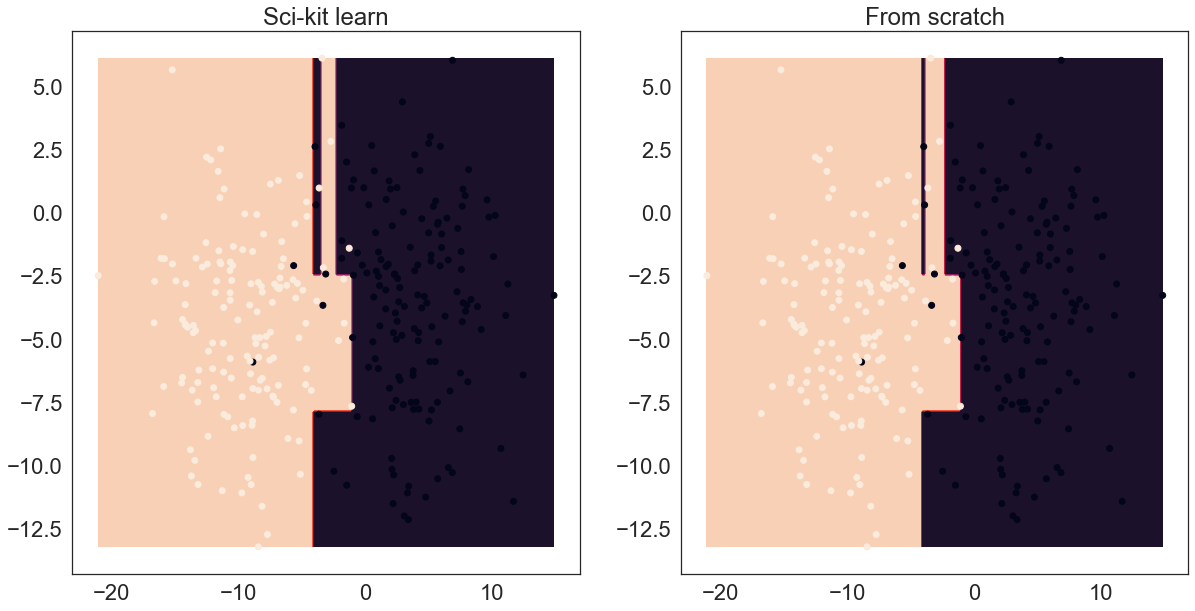

In [198]:
f, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].contourf(g1, g2, y_pred_sk.reshape(len(g1),len(g2)))
ax[0].scatter(X[:,0], X[:,1], c=y)
ax[0].set(title='Sci-kit learn')
          
ax[1].contourf(g1, g2, y_pred.reshape(len(g1),len(g2)))
ax[1].scatter(X[:,0], X[:,1], c=y)
ax[1].set(title='From scratch')